# Neural Networks for MNIST dataset

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [5]:
train_ds = datasets.MNIST('Users/davischum/data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [6]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [8]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [9]:
print(type(x),type(y))

<class 'torch.FloatTensor'> <class 'torch.LongTensor'>


In [10]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [11]:
x


(0 ,0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
           ...             ⋱             ...          
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
     ⋮ 

(1 ,0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
           ...             ⋱             ...          
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
     ⋮ 

(2 ,0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 

Helper method (from fast.ai)

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [22]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

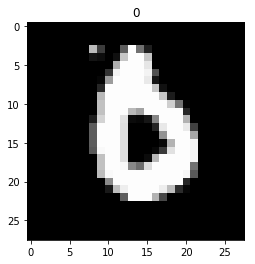

In [43]:
show(X[17][0],Y[17])

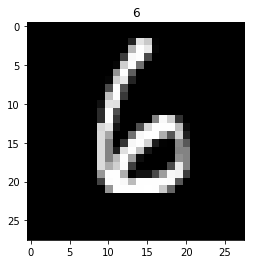

In [23]:
show(X[0][0], Y[0])

## Feed Forward Neural Network

In [8]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [9]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [10]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

In [13]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(10.61, 2.2999505783081053)

In [58]:
train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.5739
Epoch [1/2], Loss: 0.4403
Epoch [1/2], Loss: 0.3801
Epoch [1/2], Loss: 0.3497
Epoch [1/2], Loss: 0.3286
Epoch [1/2], Loss: 0.3200
Epoch [1/2], Loss: 0.3071
Epoch [1/2], Loss: 0.2961
Epoch [1/2], Loss: 0.2885
Epoch [1/2], Loss: 0.2855
Epoch [1/2], Valid Accuracy: 94.0200, Valid Loss: 0.2473
Epoch [2/2], Loss: 0.2763
Epoch [2/2], Loss: 0.2704
Epoch [2/2], Loss: 0.2660
Epoch [2/2], Loss: 0.2624
Epoch [2/2], Loss: 0.2572
Epoch [2/2], Loss: 0.2560
Epoch [2/2], Loss: 0.2528
Epoch [2/2], Loss: 0.2488
Epoch [2/2], Loss: 0.2467
Epoch [2/2], Loss: 0.2466
Epoch [2/2], Valid Accuracy: 94.6600, Valid Loss: 0.2180


(94.66, 0.2179709480047226, 0.24657609740098319)

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [59]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [27]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, 10))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [61]:
net2 = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [62]:
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.2040
Epoch [1/4], Loss: 0.1973
Epoch [1/4], Loss: 0.2093
Epoch [1/4], Loss: 0.2221
Epoch [1/4], Loss: 0.2190
Epoch [1/4], Loss: 0.2200
Epoch [1/4], Loss: 0.2229
Epoch [1/4], Loss: 0.2204
Epoch [1/4], Loss: 0.2206
Epoch [1/4], Loss: 0.2202
Epoch [1/4], Valid Accuracy: 94.7800, Valid Loss: 0.2169
Epoch [2/4], Loss: 0.2158
Epoch [2/4], Loss: 0.2110
Epoch [2/4], Loss: 0.2075
Epoch [2/4], Loss: 0.2053
Epoch [2/4], Loss: 0.2049
Epoch [2/4], Loss: 0.2049
Epoch [2/4], Loss: 0.2039
Epoch [2/4], Loss: 0.2026
Epoch [2/4], Loss: 0.2030
Epoch [2/4], Loss: 0.2016
Epoch [2/4], Valid Accuracy: 95.1500, Valid Loss: 0.2141
Epoch [3/4], Loss: 0.1987
Epoch [3/4], Loss: 0.1971
Epoch [3/4], Loss: 0.1956
Epoch [3/4], Loss: 0.1949
Epoch [3/4], Loss: 0.1937
Epoch [3/4], Loss: 0.1935
Epoch [3/4], Loss: 0.1936
Epoch [3/4], Loss: 0.1937
Epoch [3/4], Loss: 0.1926
Epoch [3/4], Loss: 0.1925
Epoch [3/4], Valid Accuracy: 95.1100, Valid Loss: 0.2608
Epoch [4/4], Loss: 0.1921
Epoch [4/4], Loss: 0.19

(95.25, 0.21190966820716858, 0.18783208012916147)

## Question 3

### Part 1

In [64]:
learning = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

In [67]:
outputs = []
for learning_rate in learning:
    print(learning_rate)
    print(" ")
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs.append(train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer))

1
 
Epoch [1/10], Loss: 1494.7945
Epoch [1/10], Loss: 749.9557
Epoch [1/10], Loss: 502.1286
Epoch [1/10], Loss: 377.4832
Epoch [1/10], Loss: 302.8861
Epoch [1/10], Loss: 252.9936
Epoch [1/10], Loss: 219.0381
Epoch [1/10], Loss: 192.1572
Epoch [1/10], Loss: 171.0730
Epoch [1/10], Loss: 164.3243
Epoch [1/10], Valid Accuracy: 10.1000, Valid Loss: 3.5312
Epoch [2/10], Loss: 149.2203
Epoch [2/10], Loss: 137.0685
Epoch [2/10], Loss: 126.1835
Epoch [2/10], Loss: 117.2607
Epoch [2/10], Loss: 109.2924
Epoch [2/10], Loss: 102.3379
Epoch [2/10], Loss: 96.2505
Epoch [2/10], Loss: 90.9848
Epoch [2/10], Loss: 86.1702
Epoch [2/10], Loss: 84.5735
Epoch [2/10], Valid Accuracy: 9.1300, Valid Loss: 2.4328
Epoch [3/10], Loss: 80.4117
Epoch [3/10], Loss: 76.6502
Epoch [3/10], Loss: 73.2351
Epoch [3/10], Loss: 70.1205
Epoch [3/10], Loss: 67.2672
Epoch [3/10], Loss: 64.6879
Epoch [3/10], Loss: 62.3132
Epoch [3/10], Loss: 60.0722
Epoch [3/10], Loss: 57.9934
Epoch [3/10], Loss: 57.2521
Epoch [3/10], Valid Accu

Epoch [5/10], Loss: 0.2076
Epoch [5/10], Loss: 0.2068
Epoch [5/10], Loss: 0.2064
Epoch [5/10], Valid Accuracy: 95.3000, Valid Loss: 0.2280
Epoch [6/10], Loss: 0.2054
Epoch [6/10], Loss: 0.2042
Epoch [6/10], Loss: 0.2038
Epoch [6/10], Loss: 0.2037
Epoch [6/10], Loss: 0.2037
Epoch [6/10], Loss: 0.2031
Epoch [6/10], Loss: 0.2022
Epoch [6/10], Loss: 0.2012
Epoch [6/10], Loss: 0.2008
Epoch [6/10], Loss: 0.2007
Epoch [6/10], Valid Accuracy: 94.7000, Valid Loss: 0.2866
Epoch [7/10], Loss: 0.2001
Epoch [7/10], Loss: 0.1992
Epoch [7/10], Loss: 0.1986
Epoch [7/10], Loss: 0.1984
Epoch [7/10], Loss: 0.1978
Epoch [7/10], Loss: 0.1973
Epoch [7/10], Loss: 0.1968
Epoch [7/10], Loss: 0.1966
Epoch [7/10], Loss: 0.1964
Epoch [7/10], Loss: 0.1962
Epoch [7/10], Valid Accuracy: 95.7200, Valid Loss: 0.2129
Epoch [8/10], Loss: 0.1950
Epoch [8/10], Loss: 0.1945
Epoch [8/10], Loss: 0.1937
Epoch [8/10], Loss: 0.1930
Epoch [8/10], Loss: 0.1920
Epoch [8/10], Loss: 0.1921
Epoch [8/10], Loss: 0.1916
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.1601
Epoch [10/10], Loss: 0.1590
Epoch [10/10], Loss: 0.1580
Epoch [10/10], Loss: 0.1575
Epoch [10/10], Valid Accuracy: 97.6600, Valid Loss: 0.0785
1e-05
 
Epoch [1/10], Loss: 2.1620
Epoch [1/10], Loss: 2.0474
Epoch [1/10], Loss: 1.9311
Epoch [1/10], Loss: 1.8193
Epoch [1/10], Loss: 1.7147
Epoch [1/10], Loss: 1.6219
Epoch [1/10], Loss: 1.5360
Epoch [1/10], Loss: 1.4616
Epoch [1/10], Loss: 1.3951
Epoch [1/10], Loss: 1.3723
Epoch [1/10], Valid Accuracy: 86.0300, Valid Loss: 0.7747
Epoch [2/10], Loss: 1.3152
Epoch [2/10], Loss: 1.2632
Epoch [2/10], Loss: 1.2163
Epoch [2/10], Loss: 1.1733
Epoch [2/10], Loss: 1.1346
Epoch [2/10], Loss: 1.0990
Epoch [2/10], Loss: 1.0660
Epoch [2/10], Loss: 1.0364
Epoch [2/10], Loss: 1.0086
Epoch [2/10], Loss: 0.9984
Epoch [2/10], Valid Accuracy: 88.8700, Valid Loss: 0.4905
Epoch [3/10], Loss: 0.9738
Epoch [3/10], Loss: 0.9505
Epoch [3/10], Loss: 0.9290
Epoch [3/10], Loss: 0.9080
Epoch [3/10], Loss: 0.8892
Epoch [3/10], Loss: 0.8714
Epo

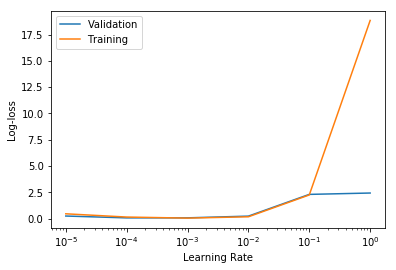

In [86]:
xvals = learning
yvals = outputs
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('Learning Rate')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()


In [88]:
learning = list(np.linspace(0.001, 0.0001, 10))

In [89]:
outputs = []
for learning_rate in learning:
    print(learning_rate)
    print(" ")
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs.append(train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer))

0.001
 
Epoch [1/10], Loss: 0.5347
Epoch [1/10], Loss: 0.4177
Epoch [1/10], Loss: 0.3587
Epoch [1/10], Loss: 0.3153
Epoch [1/10], Loss: 0.2876
Epoch [1/10], Loss: 0.2678
Epoch [1/10], Loss: 0.2481
Epoch [1/10], Loss: 0.2348
Epoch [1/10], Loss: 0.2236
Epoch [1/10], Loss: 0.2197
Epoch [1/10], Valid Accuracy: 96.4700, Valid Loss: 0.1136
Epoch [2/10], Loss: 0.2087
Epoch [2/10], Loss: 0.1993
Epoch [2/10], Loss: 0.1906
Epoch [2/10], Loss: 0.1835
Epoch [2/10], Loss: 0.1777
Epoch [2/10], Loss: 0.1712
Epoch [2/10], Loss: 0.1658
Epoch [2/10], Loss: 0.1611
Epoch [2/10], Loss: 0.1579
Epoch [2/10], Loss: 0.1563
Epoch [2/10], Valid Accuracy: 97.3000, Valid Loss: 0.0900
Epoch [3/10], Loss: 0.1511
Epoch [3/10], Loss: 0.1467
Epoch [3/10], Loss: 0.1430
Epoch [3/10], Loss: 0.1394
Epoch [3/10], Loss: 0.1360
Epoch [3/10], Loss: 0.1329
Epoch [3/10], Loss: 0.1299
Epoch [3/10], Loss: 0.1275
Epoch [3/10], Loss: 0.1253
Epoch [3/10], Loss: 0.1244
Epoch [3/10], Valid Accuracy: 97.6200, Valid Loss: 0.0728
Epoch [4

Epoch [6/10], Loss: 0.0938
Epoch [6/10], Loss: 0.0924
Epoch [6/10], Loss: 0.0911
Epoch [6/10], Loss: 0.0897
Epoch [6/10], Loss: 0.0884
Epoch [6/10], Loss: 0.0873
Epoch [6/10], Loss: 0.0862
Epoch [6/10], Loss: 0.0852
Epoch [6/10], Loss: 0.0843
Epoch [6/10], Loss: 0.0840
Epoch [6/10], Valid Accuracy: 98.0600, Valid Loss: 0.0684
Epoch [7/10], Loss: 0.0829
Epoch [7/10], Loss: 0.0818
Epoch [7/10], Loss: 0.0807
Epoch [7/10], Loss: 0.0797
Epoch [7/10], Loss: 0.0787
Epoch [7/10], Loss: 0.0778
Epoch [7/10], Loss: 0.0770
Epoch [7/10], Loss: 0.0762
Epoch [7/10], Loss: 0.0754
Epoch [7/10], Loss: 0.0751
Epoch [7/10], Valid Accuracy: 98.0600, Valid Loss: 0.0745
Epoch [8/10], Loss: 0.0742
Epoch [8/10], Loss: 0.0734
Epoch [8/10], Loss: 0.0726
Epoch [8/10], Loss: 0.0718
Epoch [8/10], Loss: 0.0710
Epoch [8/10], Loss: 0.0702
Epoch [8/10], Loss: 0.0695
Epoch [8/10], Loss: 0.0689
Epoch [8/10], Loss: 0.0683
Epoch [8/10], Loss: 0.0681
Epoch [8/10], Valid Accuracy: 97.8900, Valid Loss: 0.0847
Epoch [9/10], Lo

Epoch [1/10], Loss: 0.6823
Epoch [1/10], Loss: 0.5084
Epoch [1/10], Loss: 0.4306
Epoch [1/10], Loss: 0.3796
Epoch [1/10], Loss: 0.3485
Epoch [1/10], Loss: 0.3251
Epoch [1/10], Loss: 0.3055
Epoch [1/10], Loss: 0.2881
Epoch [1/10], Loss: 0.2727
Epoch [1/10], Loss: 0.2684
Epoch [1/10], Valid Accuracy: 95.9300, Valid Loss: 0.1421
Epoch [2/10], Loss: 0.2550
Epoch [2/10], Loss: 0.2435
Epoch [2/10], Loss: 0.2336
Epoch [2/10], Loss: 0.2250
Epoch [2/10], Loss: 0.2170
Epoch [2/10], Loss: 0.2097
Epoch [2/10], Loss: 0.2032
Epoch [2/10], Loss: 0.1974
Epoch [2/10], Loss: 0.1926
Epoch [2/10], Loss: 0.1908
Epoch [2/10], Valid Accuracy: 96.8900, Valid Loss: 0.0992
Epoch [3/10], Loss: 0.1852
Epoch [3/10], Loss: 0.1799
Epoch [3/10], Loss: 0.1753
Epoch [3/10], Loss: 0.1711
Epoch [3/10], Loss: 0.1671
Epoch [3/10], Loss: 0.1631
Epoch [3/10], Loss: 0.1593
Epoch [3/10], Loss: 0.1563
Epoch [3/10], Loss: 0.1532
Epoch [3/10], Loss: 0.1522
Epoch [3/10], Valid Accuracy: 97.3600, Valid Loss: 0.0867
Epoch [4/10], Lo

Epoch [6/10], Loss: 0.1361
Epoch [6/10], Loss: 0.1342
Epoch [6/10], Loss: 0.1324
Epoch [6/10], Loss: 0.1308
Epoch [6/10], Loss: 0.1292
Epoch [6/10], Loss: 0.1276
Epoch [6/10], Loss: 0.1260
Epoch [6/10], Loss: 0.1245
Epoch [6/10], Loss: 0.1231
Epoch [6/10], Loss: 0.1226
Epoch [6/10], Valid Accuracy: 97.8900, Valid Loss: 0.0686
Epoch [7/10], Loss: 0.1210
Epoch [7/10], Loss: 0.1196
Epoch [7/10], Loss: 0.1182
Epoch [7/10], Loss: 0.1168
Epoch [7/10], Loss: 0.1154
Epoch [7/10], Loss: 0.1141
Epoch [7/10], Loss: 0.1129
Epoch [7/10], Loss: 0.1118
Epoch [7/10], Loss: 0.1106
Epoch [7/10], Loss: 0.1102
Epoch [7/10], Valid Accuracy: 97.7800, Valid Loss: 0.0714
Epoch [8/10], Loss: 0.1090
Epoch [8/10], Loss: 0.1077
Epoch [8/10], Loss: 0.1066
Epoch [8/10], Loss: 0.1055
Epoch [8/10], Loss: 0.1044
Epoch [8/10], Loss: 0.1033
Epoch [8/10], Loss: 0.1023
Epoch [8/10], Loss: 0.1013
Epoch [8/10], Loss: 0.1003
Epoch [8/10], Loss: 0.1000
Epoch [8/10], Valid Accuracy: 97.8000, Valid Loss: 0.0685
Epoch [9/10], Lo

The Best validaition accuracy occurs at learning rate of .0005 with
Epoch [7/10], Valid Accuracy: 98.2000, Valid Loss: 0.0648

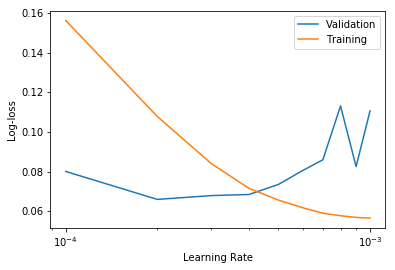

In [90]:
xvals = learning
yvals = outputs
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('Learning Rate')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()



### Part 2

In [12]:
hidden_layer_size = [10, 50, 100, 300, 1000, 2000]
learning_rate = .01
nb_epoch = 10

The hidden layer size parameter that achieved the best performance was 1000 with Valid Accuracy: 95.6300, Valid Loss: 0.2465 at epoch 7

Some of the Models are defnitely Overfitting .  I can tell since after the hidden layer size 100 the validation does not decrease anymore but begins an extreme spike up while trainig set keeps dropping. 


In [18]:
outputs1 = []
for layer_size in hidden_layer_size:
    print(layer_size)
    print(" ")
    net = get_model(M=layer_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs1.append(train_model(train_loader, test_loader, num_epochs=nb_epoch, model=net, optimizer=optimizer))

10
 
Epoch [1/10], Loss: 1.1083
Epoch [1/10], Loss: 0.9154
Epoch [1/10], Loss: 0.8394
Epoch [1/10], Loss: 0.7877
Epoch [1/10], Loss: 0.7560
Epoch [1/10], Loss: 0.7282
Epoch [1/10], Loss: 0.7077
Epoch [1/10], Loss: 0.6900
Epoch [1/10], Loss: 0.6741
Epoch [1/10], Loss: 0.6676
Epoch [1/10], Valid Accuracy: 84.4800, Valid Loss: 0.5360
Epoch [2/10], Loss: 0.6579
Epoch [2/10], Loss: 0.6505
Epoch [2/10], Loss: 0.6406
Epoch [2/10], Loss: 0.6341
Epoch [2/10], Loss: 0.6278
Epoch [2/10], Loss: 0.6212
Epoch [2/10], Loss: 0.6174
Epoch [2/10], Loss: 0.6128
Epoch [2/10], Loss: 0.6085
Epoch [2/10], Loss: 0.6068
Epoch [2/10], Valid Accuracy: 84.4000, Valid Loss: 0.5430
Epoch [3/10], Loss: 0.6023
Epoch [3/10], Loss: 0.5979
Epoch [3/10], Loss: 0.5943
Epoch [3/10], Loss: 0.5921
Epoch [3/10], Loss: 0.5894
Epoch [3/10], Loss: 0.5870
Epoch [3/10], Loss: 0.5841
Epoch [3/10], Loss: 0.5821
Epoch [3/10], Loss: 0.5792
Epoch [3/10], Loss: 0.5782
Epoch [3/10], Valid Accuracy: 85.4300, Valid Loss: 0.5114
Epoch [4/10

Epoch [6/10], Loss: 0.2052
Epoch [6/10], Loss: 0.2039
Epoch [6/10], Loss: 0.2027
Epoch [6/10], Loss: 0.2017
Epoch [6/10], Loss: 0.2011
Epoch [6/10], Loss: 0.2005
Epoch [6/10], Loss: 0.1999
Epoch [6/10], Loss: 0.1991
Epoch [6/10], Loss: 0.1989
Epoch [6/10], Loss: 0.1987
Epoch [6/10], Valid Accuracy: 94.8900, Valid Loss: 0.2557
Epoch [7/10], Loss: 0.1979
Epoch [7/10], Loss: 0.1972
Epoch [7/10], Loss: 0.1962
Epoch [7/10], Loss: 0.1957
Epoch [7/10], Loss: 0.1953
Epoch [7/10], Loss: 0.1953
Epoch [7/10], Loss: 0.1953
Epoch [7/10], Loss: 0.1950
Epoch [7/10], Loss: 0.1951
Epoch [7/10], Loss: 0.1949
Epoch [7/10], Valid Accuracy: 94.9500, Valid Loss: 0.2205
Epoch [8/10], Loss: 0.1939
Epoch [8/10], Loss: 0.1933
Epoch [8/10], Loss: 0.1927
Epoch [8/10], Loss: 0.1921
Epoch [8/10], Loss: 0.1920
Epoch [8/10], Loss: 0.1917
Epoch [8/10], Loss: 0.1915
Epoch [8/10], Loss: 0.1908
Epoch [8/10], Loss: 0.1908
Epoch [8/10], Loss: 0.1906
Epoch [8/10], Valid Accuracy: 95.0900, Valid Loss: 0.2712
Epoch [9/10], Lo

Epoch [1/10], Loss: 1.1028
Epoch [1/10], Loss: 0.7143
Epoch [1/10], Loss: 0.5775
Epoch [1/10], Loss: 0.4963
Epoch [1/10], Loss: 0.4552
Epoch [1/10], Loss: 0.4213
Epoch [1/10], Loss: 0.3962
Epoch [1/10], Loss: 0.3729
Epoch [1/10], Loss: 0.3624
Epoch [1/10], Loss: 0.3582
Epoch [1/10], Valid Accuracy: 93.5000, Valid Loss: 0.2560
Epoch [2/10], Loss: 0.3429
Epoch [2/10], Loss: 0.3318
Epoch [2/10], Loss: 0.3232
Epoch [2/10], Loss: 0.3161
Epoch [2/10], Loss: 0.3097
Epoch [2/10], Loss: 0.3044
Epoch [2/10], Loss: 0.3025
Epoch [2/10], Loss: 0.2995
Epoch [2/10], Loss: 0.2954
Epoch [2/10], Loss: 0.2931
Epoch [2/10], Valid Accuracy: 94.4600, Valid Loss: 0.2424
Epoch [3/10], Loss: 0.2878
Epoch [3/10], Loss: 0.2832
Epoch [3/10], Loss: 0.2796
Epoch [3/10], Loss: 0.2769
Epoch [3/10], Loss: 0.2738
Epoch [3/10], Loss: 0.2712
Epoch [3/10], Loss: 0.2684
Epoch [3/10], Loss: 0.2654
Epoch [3/10], Loss: 0.2636
Epoch [3/10], Loss: 0.2624
Epoch [3/10], Valid Accuracy: 94.8700, Valid Loss: 0.2277
Epoch [4/10], Lo

In [16]:
outputs1

[(90.7, 0.33315039677619934, 0.33563735175887743),
 (95.97, 0.23367455637454987, 0.18433604288756847),
 (95.1, 0.23079078378677367, 0.18262107044100762),
 (94.76, 0.28340427007675173, 0.18376148855507374),
 (95.2, 0.2819641561508179, 0.19130376025001208),
 (95.52, 0.27166724324226377, 0.19674135042468707)]

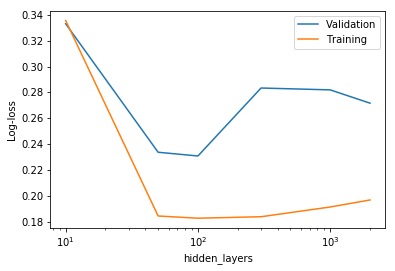

In [17]:
xvals = hidden_layer_size
yvals = outputs1
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('hidden_layers')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()



### Part 3

In [19]:
weight_decay = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
M = 300
learning_rate = .001
nb_epoch = 20

In [20]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

outputs2 = []
for weight in weight_decay:
    print(weight)
    print(" ")
    net = get_model(M)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay= weight)
    outputs2.append(train_model(train_loader, test_loader, num_epochs=nb_epoch, model=net, optimizer=optimizer))

0
 
Epoch [1/20], Loss: 0.5334
Epoch [1/20], Loss: 0.4178
Epoch [1/20], Loss: 0.3623
Epoch [1/20], Loss: 0.3190
Epoch [1/20], Loss: 0.2876
Epoch [1/20], Loss: 0.2667
Epoch [1/20], Loss: 0.2482
Epoch [1/20], Loss: 0.2346
Epoch [1/20], Loss: 0.2231
Epoch [1/20], Loss: 0.2191
Epoch [1/20], Valid Accuracy: 96.4400, Valid Loss: 0.1203
Epoch [2/20], Loss: 0.2083
Epoch [2/20], Loss: 0.1974
Epoch [2/20], Loss: 0.1885
Epoch [2/20], Loss: 0.1819
Epoch [2/20], Loss: 0.1755
Epoch [2/20], Loss: 0.1697
Epoch [2/20], Loss: 0.1651
Epoch [2/20], Loss: 0.1603
Epoch [2/20], Loss: 0.1563
Epoch [2/20], Loss: 0.1546
Epoch [2/20], Valid Accuracy: 97.4900, Valid Loss: 0.0854
Epoch [3/20], Loss: 0.1498
Epoch [3/20], Loss: 0.1452
Epoch [3/20], Loss: 0.1413
Epoch [3/20], Loss: 0.1379
Epoch [3/20], Loss: 0.1345
Epoch [3/20], Loss: 0.1317
Epoch [3/20], Loss: 0.1292
Epoch [3/20], Loss: 0.1268
Epoch [3/20], Loss: 0.1246
Epoch [3/20], Loss: 0.1237
Epoch [3/20], Valid Accuracy: 97.7000, Valid Loss: 0.0813
Epoch [4/20]

Epoch [5/20], Loss: 0.0959
Epoch [5/20], Loss: 0.0949
Epoch [5/20], Loss: 0.0944
Epoch [5/20], Valid Accuracy: 97.7200, Valid Loss: 0.0780
Epoch [6/20], Loss: 0.0933
Epoch [6/20], Loss: 0.0919
Epoch [6/20], Loss: 0.0907
Epoch [6/20], Loss: 0.0897
Epoch [6/20], Loss: 0.0885
Epoch [6/20], Loss: 0.0875
Epoch [6/20], Loss: 0.0866
Epoch [6/20], Loss: 0.0858
Epoch [6/20], Loss: 0.0850
Epoch [6/20], Loss: 0.0847
Epoch [6/20], Valid Accuracy: 97.8600, Valid Loss: 0.0710
Epoch [7/20], Loss: 0.0838
Epoch [7/20], Loss: 0.0826
Epoch [7/20], Loss: 0.0816
Epoch [7/20], Loss: 0.0809
Epoch [7/20], Loss: 0.0803
Epoch [7/20], Loss: 0.0796
Epoch [7/20], Loss: 0.0789
Epoch [7/20], Loss: 0.0781
Epoch [7/20], Loss: 0.0774
Epoch [7/20], Loss: 0.0772
Epoch [7/20], Valid Accuracy: 97.6300, Valid Loss: 0.0827
Epoch [8/20], Loss: 0.0763
Epoch [8/20], Loss: 0.0755
Epoch [8/20], Loss: 0.0747
Epoch [8/20], Loss: 0.0740
Epoch [8/20], Loss: 0.0732
Epoch [8/20], Loss: 0.0725
Epoch [8/20], Loss: 0.0720
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0905
Epoch [10/20], Loss: 0.0902
Epoch [10/20], Loss: 0.0899
Epoch [10/20], Loss: 0.0897
Epoch [10/20], Loss: 0.0894
Epoch [10/20], Loss: 0.0891
Epoch [10/20], Loss: 0.0887
Epoch [10/20], Loss: 0.0887
Epoch [10/20], Valid Accuracy: 97.1700, Valid Loss: 0.0852
Epoch [11/20], Loss: 0.0882
Epoch [11/20], Loss: 0.0879
Epoch [11/20], Loss: 0.0876
Epoch [11/20], Loss: 0.0873
Epoch [11/20], Loss: 0.0870
Epoch [11/20], Loss: 0.0867
Epoch [11/20], Loss: 0.0864
Epoch [11/20], Loss: 0.0863
Epoch [11/20], Loss: 0.0861
Epoch [11/20], Loss: 0.0859
Epoch [11/20], Valid Accuracy: 97.9100, Valid Loss: 0.0667
Epoch [12/20], Loss: 0.0855
Epoch [12/20], Loss: 0.0851
Epoch [12/20], Loss: 0.0849
Epoch [12/20], Loss: 0.0846
Epoch [12/20], Loss: 0.0843
Epoch [12/20], Loss: 0.0840
Epoch [12/20], Loss: 0.0837
Epoch [12/20], Loss: 0.0836
Epoch [12/20], Loss: 0.0834
Epoch [12/20], Loss: 0.0833
Epoch [12/20], Valid Accuracy: 97.5500, Valid Loss: 0.0832
Epoch [13/20], Loss: 0.0829
Epoch [13/2

Epoch [14/20], Loss: 0.1743
Epoch [14/20], Loss: 0.1743
Epoch [14/20], Valid Accuracy: 95.9300, Valid Loss: 0.1513
Epoch [15/20], Loss: 0.1742
Epoch [15/20], Loss: 0.1740
Epoch [15/20], Loss: 0.1738
Epoch [15/20], Loss: 0.1736
Epoch [15/20], Loss: 0.1735
Epoch [15/20], Loss: 0.1734
Epoch [15/20], Loss: 0.1733
Epoch [15/20], Loss: 0.1733
Epoch [15/20], Loss: 0.1731
Epoch [15/20], Loss: 0.1731
Epoch [15/20], Valid Accuracy: 96.2000, Valid Loss: 0.1493
Epoch [16/20], Loss: 0.1729
Epoch [16/20], Loss: 0.1727
Epoch [16/20], Loss: 0.1726
Epoch [16/20], Loss: 0.1725
Epoch [16/20], Loss: 0.1725
Epoch [16/20], Loss: 0.1724
Epoch [16/20], Loss: 0.1723
Epoch [16/20], Loss: 0.1721
Epoch [16/20], Loss: 0.1721
Epoch [16/20], Loss: 0.1720
Epoch [16/20], Valid Accuracy: 96.4100, Valid Loss: 0.1403
Epoch [17/20], Loss: 0.1718
Epoch [17/20], Loss: 0.1718
Epoch [17/20], Loss: 0.1717
Epoch [17/20], Loss: 0.1715
Epoch [17/20], Loss: 0.1715
Epoch [17/20], Loss: 0.1714
Epoch [17/20], Loss: 0.1713
Epoch [17/2

Epoch [19/20], Loss: 0.4716
Epoch [19/20], Loss: 0.4716
Epoch [19/20], Loss: 0.4715
Epoch [19/20], Loss: 0.4714
Epoch [19/20], Loss: 0.4714
Epoch [19/20], Loss: 0.4714
Epoch [19/20], Loss: 0.4713
Epoch [19/20], Loss: 0.4713
Epoch [19/20], Valid Accuracy: 89.6000, Valid Loss: 0.4502
Epoch [20/20], Loss: 0.4713
Epoch [20/20], Loss: 0.4712
Epoch [20/20], Loss: 0.4711
Epoch [20/20], Loss: 0.4710
Epoch [20/20], Loss: 0.4710
Epoch [20/20], Loss: 0.4710
Epoch [20/20], Loss: 0.4709
Epoch [20/20], Loss: 0.4709
Epoch [20/20], Loss: 0.4708
Epoch [20/20], Loss: 0.4708
Epoch [20/20], Valid Accuracy: 90.4400, Valid Loss: 0.4297
0.3
 
Epoch [1/20], Loss: 1.0060
Epoch [1/20], Loss: 0.9366
Epoch [1/20], Loss: 0.9072
Epoch [1/20], Loss: 0.8938
Epoch [1/20], Loss: 0.8864
Epoch [1/20], Loss: 0.8795
Epoch [1/20], Loss: 0.8734
Epoch [1/20], Loss: 0.8684
Epoch [1/20], Loss: 0.8636
Epoch [1/20], Loss: 0.8626
Epoch [1/20], Valid Accuracy: 79.3600, Valid Loss: 0.8271
Epoch [2/20], Loss: 0.8601
Epoch [2/20], Los

In [21]:
outputs2

[(97.8, 0.13612986100912094, 0.033571735351706544),
 (97.88, 0.0829718011200428, 0.03991602797567844),
 (97.81, 0.06923761384487152, 0.07127643372267485),
 (95.64, 0.15654331076145173, 0.1689123510235548),
 (90.44, 0.42971775135993956, 0.47080080397288004),
 (86.08, 0.7943982673645019, 0.8184058789316813)]

Best weight decay is .0001

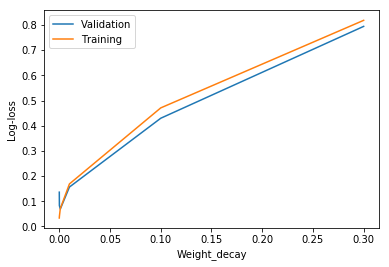

In [23]:
xvals = weight_decay
yvals = outputs2
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
#plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('Weight_decay')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()

### Part 4

In [24]:
drop_out_rates = list(np.arange(0,11)/10)
M = 300
learning_rate = .001
np_epoch = 20

In [36]:
drop_out_rates

[0.0,
 0.10000000000000001,
 0.20000000000000001,
 0.29999999999999999,
 0.40000000000000002,
 0.5,
 0.59999999999999998,
 0.69999999999999996,
 0.80000000000000004,
 0.90000000000000002,
 1.0]

In [28]:
outputs3 = []
for p in drop_out_rates:
    net2 = get_model_v2(M, p)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs3.append(train_model(train_loader,\
    test_loader, num_epochs=4, model=net, optimizer=optimizer))

Epoch [1/4], Loss: 0.4576
Epoch [1/4], Loss: 0.3706
Epoch [1/4], Loss: 0.3273
Epoch [1/4], Loss: 0.2974
Epoch [1/4], Loss: 0.2753
Epoch [1/4], Loss: 0.2563
Epoch [1/4], Loss: 0.2429
Epoch [1/4], Loss: 0.2296
Epoch [1/4], Loss: 0.2190
Epoch [1/4], Loss: 0.2160
Epoch [1/4], Valid Accuracy: 96.3000, Valid Loss: 0.1218
Epoch [2/4], Loss: 0.2047
Epoch [2/4], Loss: 0.1953
Epoch [2/4], Loss: 0.1876
Epoch [2/4], Loss: 0.1801
Epoch [2/4], Loss: 0.1733
Epoch [2/4], Loss: 0.1677
Epoch [2/4], Loss: 0.1634
Epoch [2/4], Loss: 0.1588
Epoch [2/4], Loss: 0.1549
Epoch [2/4], Loss: 0.1537
Epoch [2/4], Valid Accuracy: 97.3900, Valid Loss: 0.0871
Epoch [3/4], Loss: 0.1490
Epoch [3/4], Loss: 0.1446
Epoch [3/4], Loss: 0.1410
Epoch [3/4], Loss: 0.1375
Epoch [3/4], Loss: 0.1343
Epoch [3/4], Loss: 0.1313
Epoch [3/4], Loss: 0.1284
Epoch [3/4], Loss: 0.1260
Epoch [3/4], Loss: 0.1239
Epoch [3/4], Loss: 0.1231
Epoch [3/4], Valid Accuracy: 97.6000, Valid Loss: 0.0770
Epoch [4/4], Loss: 0.1203
Epoch [4/4], Loss: 0.11

Epoch [3/4], Loss: 0.0078
Epoch [3/4], Loss: 0.0080
Epoch [3/4], Loss: 0.0080
Epoch [3/4], Loss: 0.0078
Epoch [3/4], Loss: 0.0077
Epoch [3/4], Loss: 0.0076
Epoch [3/4], Loss: 0.0075
Epoch [3/4], Loss: 0.0073
Epoch [3/4], Loss: 0.0072
Epoch [3/4], Loss: 0.0072
Epoch [3/4], Valid Accuracy: 98.1500, Valid Loss: 0.1383
Epoch [4/4], Loss: 0.0072
Epoch [4/4], Loss: 0.0071
Epoch [4/4], Loss: 0.0071
Epoch [4/4], Loss: 0.0070
Epoch [4/4], Loss: 0.0069
Epoch [4/4], Loss: 0.0070
Epoch [4/4], Loss: 0.0069
Epoch [4/4], Loss: 0.0069
Epoch [4/4], Loss: 0.0069
Epoch [4/4], Loss: 0.0069
Epoch [4/4], Valid Accuracy: 97.9900, Valid Loss: 0.1458
Epoch [1/4], Loss: 0.0051
Epoch [1/4], Loss: 0.0064
Epoch [1/4], Loss: 0.0089
Epoch [1/4], Loss: 0.0083
Epoch [1/4], Loss: 0.0083
Epoch [1/4], Loss: 0.0081
Epoch [1/4], Loss: 0.0078
Epoch [1/4], Loss: 0.0081
Epoch [1/4], Loss: 0.0080
Epoch [1/4], Loss: 0.0080
Epoch [1/4], Valid Accuracy: 98.1400, Valid Loss: 0.1480
Epoch [2/4], Loss: 0.0074
Epoch [2/4], Loss: 0.00

In [31]:
outputs3

[(97.89, 0.07000007654428482, 0.10384668028528492),
 (98.02, 0.0771197162747383, 0.027203015538367133),
 (97.87, 0.09485387496352196, 0.0156961649829677),
 (98.08, 0.10343131820559502, 0.010801627597709498),
 (98.01, 0.1160388792105019, 0.009488842493481933),
 (97.58, 0.13611550728082658, 0.0074948955329600725),
 (97.99, 0.14584113542437555, 0.00693798300914544),
 (97.65, 0.17914903914108873, 0.006816563626747423),
 (97.99, 0.15320808056741952, 0.006168598554104877),
 (97.9, 0.18253087828457357, 0.00667317784697904),
 (98.16, 0.17161455015689134, 0.006122661850557779)]

We achieve maximum accuracy at a drop out rate of 1.  Which implies in this example During training, randomly zeroes some of the elements of the input tensor with probability **1** using samples from a bernoulli distribution gives us the optimal result.

Dropout help to increase test accuracy due to the fact that each hidden unit in a neural network trained with dropout must learn to work with a randomly chosen sample of other units. This should make each hidden unit more robust and drive it towards creating useful features on its own without relying on other hidden units to correct its mistakes. However, the hidden units within a layer will still learn to do different things from each other. One might imagine that the net would become robust against dropout by making many copies of each hidden unit.

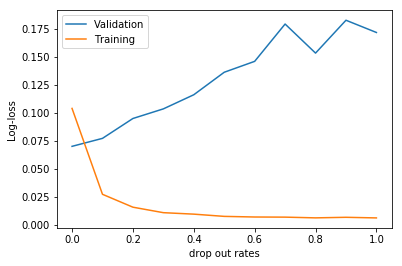

In [35]:
xvals = drop_out_rates
yvals = outputs3
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
#plt.plot(xvals, [k for k,_,_ in yvals], label = 'Prediction')
plt.legend()
#plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('drop out rates')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()

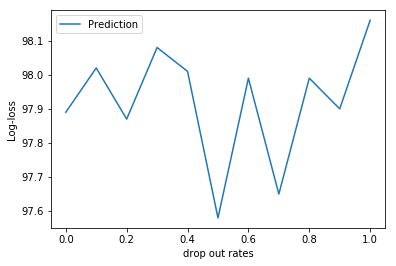

In [34]:
xvals = drop_out_rates
yvals = outputs3
#plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
#plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.plot(xvals, [k for k,_,_ in yvals], label = 'Prediction')
plt.legend()
#plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('drop out rates')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()

## Part 5

In [37]:
def get_model_three_layer(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [38]:
net = get_model_three_layer()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(12.48, 2.3013604877471923)

1
 
Epoch [1/10], Loss: 13661.5940
Epoch [1/10], Loss: 6913.2865
Epoch [1/10], Loss: 4766.7828
Epoch [1/10], Loss: 3748.6966
Epoch [1/10], Loss: 3201.6751
Epoch [1/10], Loss: 2758.9090
Epoch [1/10], Loss: 2877.5844
Epoch [1/10], Loss: 2518.1808
Epoch [1/10], Loss: 2399.1146
Epoch [1/10], Loss: 2323.8419
Epoch [1/10], Valid Accuracy: 9.8300, Valid Loss: 1246.5989
Epoch [2/10], Loss: 2134.7366
Epoch [2/10], Loss: 2023.8602
Epoch [2/10], Loss: 1861.7532
Epoch [2/10], Loss: 1772.7929
Epoch [2/10], Loss: 1649.6317
Epoch [2/10], Loss: 1619.9855
Epoch [2/10], Loss: 1521.2001
Epoch [2/10], Loss: 1433.7852
Epoch [2/10], Loss: 1355.8849
Epoch [2/10], Loss: 1328.8144
Epoch [2/10], Valid Accuracy: 10.1000, Valid Loss: 7.6158
Epoch [3/10], Loss: 1261.6527
Epoch [3/10], Loss: 1200.9649
Epoch [3/10], Loss: 1145.8568
Epoch [3/10], Loss: 1095.5951
Epoch [3/10], Loss: 1049.5648
Epoch [3/10], Loss: 1007.2535
Epoch [3/10], Loss: 968.2289
Epoch [3/10], Loss: 932.1220
Epoch [3/10], Loss: 898.6173
Epoch [3/1

Epoch [5/10], Loss: 0.2170
Epoch [5/10], Loss: 0.2155
Epoch [5/10], Loss: 0.2142
Epoch [5/10], Loss: 0.2130
Epoch [5/10], Loss: 0.2123
Epoch [5/10], Loss: 0.2110
Epoch [5/10], Loss: 0.2107
Epoch [5/10], Valid Accuracy: 95.1200, Valid Loss: 0.2054
Epoch [6/10], Loss: 0.2094
Epoch [6/10], Loss: 0.2081
Epoch [6/10], Loss: 0.2067
Epoch [6/10], Loss: 0.2056
Epoch [6/10], Loss: 0.2043
Epoch [6/10], Loss: 0.2035
Epoch [6/10], Loss: 0.2028
Epoch [6/10], Loss: 0.2019
Epoch [6/10], Loss: 0.2018
Epoch [6/10], Loss: 0.2017
Epoch [6/10], Valid Accuracy: 95.4500, Valid Loss: 0.1905
Epoch [7/10], Loss: 0.2003
Epoch [7/10], Loss: 0.1990
Epoch [7/10], Loss: 0.1980
Epoch [7/10], Loss: 0.1968
Epoch [7/10], Loss: 0.1959
Epoch [7/10], Loss: 0.1950
Epoch [7/10], Loss: 0.1944
Epoch [7/10], Loss: 0.1938
Epoch [7/10], Loss: 0.1933
Epoch [7/10], Loss: 0.1933
Epoch [7/10], Valid Accuracy: 95.5200, Valid Loss: 0.1990
Epoch [8/10], Loss: 0.1924
Epoch [8/10], Loss: 0.1916
Epoch [8/10], Loss: 0.1907
Epoch [8/10], Lo

Epoch [10/10], Loss: 0.1328
Epoch [10/10], Loss: 0.1317
Epoch [10/10], Loss: 0.1306
Epoch [10/10], Loss: 0.1295
Epoch [10/10], Loss: 0.1285
Epoch [10/10], Loss: 0.1275
Epoch [10/10], Loss: 0.1265
Epoch [10/10], Loss: 0.1262
Epoch [10/10], Valid Accuracy: 97.9100, Valid Loss: 0.0675
1e-05
 
Epoch [1/10], Loss: 2.2331
Epoch [1/10], Loss: 2.1564
Epoch [1/10], Loss: 2.0631
Epoch [1/10], Loss: 1.9536
Epoch [1/10], Loss: 1.8370
Epoch [1/10], Loss: 1.7253
Epoch [1/10], Loss: 1.6198
Epoch [1/10], Loss: 1.5247
Epoch [1/10], Loss: 1.4403
Epoch [1/10], Loss: 1.4115
Epoch [1/10], Valid Accuracy: 85.6200, Valid Loss: 0.6808
Epoch [2/10], Loss: 1.3392
Epoch [2/10], Loss: 1.2759
Epoch [2/10], Loss: 1.2201
Epoch [2/10], Loss: 1.1702
Epoch [2/10], Loss: 1.1251
Epoch [2/10], Loss: 1.0848
Epoch [2/10], Loss: 1.0471
Epoch [2/10], Loss: 1.0137
Epoch [2/10], Loss: 0.9824
Epoch [2/10], Loss: 0.9712
Epoch [2/10], Valid Accuracy: 89.2500, Valid Loss: 0.4152
Epoch [3/10], Loss: 0.9433
Epoch [3/10], Loss: 0.9177

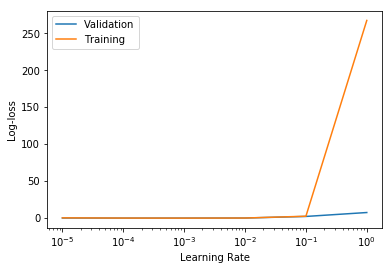

In [15]:
learning = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
outputs = []
for learning_rate in learning:
    print(learning_rate)
    print(" ")
    net = get_model_three_layer()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs.append(train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer))

xvals = learning
yvals = outputs
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('Learning Rate')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()    

Optimum learning rate at .0005

In [42]:
hidden_layer_size = [10, 50, 100, 300, 1000, 2000]
learning_rate = .0005
nb_epoch = 3
outputs1 = []
for layer_size in hidden_layer_size:
    print(layer_size)
    print(" ")
    net = get_model_three_layer(M=layer_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs1.append(train_model(train_loader, test_loader, num_epochs=nb_epoch, model=net, optimizer=optimizer))



10
 
Epoch [1/3], Loss: 1.8783
Epoch [1/3], Loss: 1.5042
Epoch [1/3], Loss: 1.2495
Epoch [1/3], Loss: 1.0828
Epoch [1/3], Loss: 0.9698
Epoch [1/3], Loss: 0.8819
Epoch [1/3], Loss: 0.8148
Epoch [1/3], Loss: 0.7633
Epoch [1/3], Loss: 0.7203
Epoch [1/3], Loss: 0.7066
Epoch [1/3], Valid Accuracy: 89.3900, Valid Loss: 0.3714
Epoch [2/3], Loss: 0.6739
Epoch [2/3], Loss: 0.6472
Epoch [2/3], Loss: 0.6236
Epoch [2/3], Loss: 0.6014
Epoch [2/3], Loss: 0.5837
Epoch [2/3], Loss: 0.5669
Epoch [2/3], Loss: 0.5519
Epoch [2/3], Loss: 0.5389
Epoch [2/3], Loss: 0.5268
Epoch [2/3], Loss: 0.5226
Epoch [2/3], Valid Accuracy: 91.2000, Valid Loss: 0.3050
Epoch [3/3], Loss: 0.5114
Epoch [3/3], Loss: 0.5016
Epoch [3/3], Loss: 0.4921
Epoch [3/3], Loss: 0.4837
Epoch [3/3], Loss: 0.4762
Epoch [3/3], Loss: 0.4689
Epoch [3/3], Loss: 0.4624
Epoch [3/3], Loss: 0.4563
Epoch [3/3], Loss: 0.4500
Epoch [3/3], Loss: 0.4477
Epoch [3/3], Valid Accuracy: 91.7100, Valid Loss: 0.2864
50
 
Epoch [1/3], Loss: 1.1506
Epoch [1/3], 

In [43]:
outputs1

[(91.71, 0.28636016697883604, 0.44767482988569474),
 (96.01, 0.13154630596637726, 0.2449098705192407),
 (96.77, 0.10557126173973083, 0.19205181405411825),
 (97.54, 0.07982434561252594, 0.13688370554513402),
 (97.78, 0.0753451664686203, 0.10944656995866034),
 (97.85, 0.07645839085578919, 0.10634614385035303)]

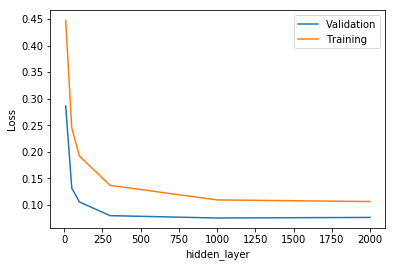

In [45]:
xvals = hidden_layer_size
yvals = outputs1
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
#plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('hidden_layer')
plt.ylabel('Loss')
# plt.show()
plt.figure()  

optimal  M = 2000

In [50]:
weight_decay = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
M = 2000
learning_rate = .0005
nb_epoch = 20

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

outputs2 = []
for weight in weight_decay:
    print(weight)
    print(" ")
    net = get_model_three_layer(M)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay= weight)
    outputs2.append(train_model(train_loader, test_loader, num_epochs=nb_epoch, model=net, optimizer=optimizer))
    
    

0
 
Epoch [1/20], Loss: 0.4464
Epoch [1/20], Loss: 0.3403
Epoch [1/20], Loss: 0.2958
Epoch [1/20], Loss: 0.2596
Epoch [1/20], Loss: 0.2419
Epoch [1/20], Loss: 0.2285
Epoch [1/20], Loss: 0.2176
Epoch [1/20], Loss: 0.2064
Epoch [1/20], Loss: 0.1979
Epoch [1/20], Loss: 0.1943
Epoch [1/20], Valid Accuracy: 95.8300, Valid Loss: 0.1360
Epoch [2/20], Loss: 0.1837
Epoch [2/20], Loss: 0.1748
Epoch [2/20], Loss: 0.1694
Epoch [2/20], Loss: 0.1643
Epoch [2/20], Loss: 0.1598
Epoch [2/20], Loss: 0.1568
Epoch [2/20], Loss: 0.1534
Epoch [2/20], Loss: 0.1492
Epoch [2/20], Loss: 0.1457
Epoch [2/20], Loss: 0.1449
Epoch [2/20], Valid Accuracy: 97.1000, Valid Loss: 0.0972
Epoch [3/20], Loss: 0.1413
Epoch [3/20], Loss: 0.1375
Epoch [3/20], Loss: 0.1344
Epoch [3/20], Loss: 0.1317
Epoch [3/20], Loss: 0.1290
Epoch [3/20], Loss: 0.1270
Epoch [3/20], Loss: 0.1252
Epoch [3/20], Loss: 0.1230
Epoch [3/20], Loss: 0.1207
Epoch [3/20], Loss: 0.1198
Epoch [3/20], Valid Accuracy: 97.4000, Valid Loss: 0.0870
Epoch [4/20]

Epoch [5/20], Loss: 0.0963
Epoch [5/20], Loss: 0.0955
Epoch [5/20], Loss: 0.0952
Epoch [5/20], Valid Accuracy: 97.4300, Valid Loss: 0.0893
Epoch [6/20], Loss: 0.0941
Epoch [6/20], Loss: 0.0928
Epoch [6/20], Loss: 0.0916
Epoch [6/20], Loss: 0.0907
Epoch [6/20], Loss: 0.0898
Epoch [6/20], Loss: 0.0889
Epoch [6/20], Loss: 0.0883
Epoch [6/20], Loss: 0.0875
Epoch [6/20], Loss: 0.0867
Epoch [6/20], Loss: 0.0864
Epoch [6/20], Valid Accuracy: 98.1300, Valid Loss: 0.0695
Epoch [7/20], Loss: 0.0855
Epoch [7/20], Loss: 0.0845
Epoch [7/20], Loss: 0.0836
Epoch [7/20], Loss: 0.0827
Epoch [7/20], Loss: 0.0820
Epoch [7/20], Loss: 0.0814
Epoch [7/20], Loss: 0.0807
Epoch [7/20], Loss: 0.0801
Epoch [7/20], Loss: 0.0795
Epoch [7/20], Loss: 0.0793
Epoch [7/20], Valid Accuracy: 97.6300, Valid Loss: 0.0817
Epoch [8/20], Loss: 0.0785
Epoch [8/20], Loss: 0.0778
Epoch [8/20], Loss: 0.0771
Epoch [8/20], Loss: 0.0765
Epoch [8/20], Loss: 0.0758
Epoch [8/20], Loss: 0.0752
Epoch [8/20], Loss: 0.0748
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0910
Epoch [10/20], Loss: 0.0907
Epoch [10/20], Loss: 0.0904
Epoch [10/20], Loss: 0.0901
Epoch [10/20], Loss: 0.0897
Epoch [10/20], Loss: 0.0894
Epoch [10/20], Loss: 0.0891
Epoch [10/20], Loss: 0.0889
Epoch [10/20], Valid Accuracy: 97.5000, Valid Loss: 0.0770
Epoch [11/20], Loss: 0.0884
Epoch [11/20], Loss: 0.0881
Epoch [11/20], Loss: 0.0878
Epoch [11/20], Loss: 0.0874
Epoch [11/20], Loss: 0.0870
Epoch [11/20], Loss: 0.0867
Epoch [11/20], Loss: 0.0864
Epoch [11/20], Loss: 0.0862
Epoch [11/20], Loss: 0.0859
Epoch [11/20], Loss: 0.0858
Epoch [11/20], Valid Accuracy: 97.3500, Valid Loss: 0.0852
Epoch [12/20], Loss: 0.0854
Epoch [12/20], Loss: 0.0851
Epoch [12/20], Loss: 0.0847
Epoch [12/20], Loss: 0.0845
Epoch [12/20], Loss: 0.0843
Epoch [12/20], Loss: 0.0841
Epoch [12/20], Loss: 0.0838
Epoch [12/20], Loss: 0.0836
Epoch [12/20], Loss: 0.0834
Epoch [12/20], Loss: 0.0833
Epoch [12/20], Valid Accuracy: 97.8000, Valid Loss: 0.0723
Epoch [13/20], Loss: 0.0830
Epoch [13/2

Epoch [14/20], Loss: 0.1663
Epoch [14/20], Loss: 0.1663
Epoch [14/20], Valid Accuracy: 95.7500, Valid Loss: 0.1455
Epoch [15/20], Loss: 0.1661
Epoch [15/20], Loss: 0.1660
Epoch [15/20], Loss: 0.1658
Epoch [15/20], Loss: 0.1657
Epoch [15/20], Loss: 0.1656
Epoch [15/20], Loss: 0.1654
Epoch [15/20], Loss: 0.1653
Epoch [15/20], Loss: 0.1652
Epoch [15/20], Loss: 0.1652
Epoch [15/20], Loss: 0.1651
Epoch [15/20], Valid Accuracy: 96.4500, Valid Loss: 0.1386
Epoch [16/20], Loss: 0.1650
Epoch [16/20], Loss: 0.1649
Epoch [16/20], Loss: 0.1647
Epoch [16/20], Loss: 0.1646
Epoch [16/20], Loss: 0.1644
Epoch [16/20], Loss: 0.1643
Epoch [16/20], Loss: 0.1642
Epoch [16/20], Loss: 0.1642
Epoch [16/20], Loss: 0.1641
Epoch [16/20], Loss: 0.1641
Epoch [16/20], Valid Accuracy: 96.0700, Valid Loss: 0.1407
Epoch [17/20], Loss: 0.1639
Epoch [17/20], Loss: 0.1638
Epoch [17/20], Loss: 0.1637
Epoch [17/20], Loss: 0.1636
Epoch [17/20], Loss: 0.1636
Epoch [17/20], Loss: 0.1635
Epoch [17/20], Loss: 0.1634
Epoch [17/2

Epoch [19/20], Loss: 0.5541
Epoch [19/20], Loss: 0.5540
Epoch [19/20], Loss: 0.5541
Epoch [19/20], Loss: 0.5541
Epoch [19/20], Loss: 0.5541
Epoch [19/20], Loss: 0.5540
Epoch [19/20], Loss: 0.5539
Epoch [19/20], Loss: 0.5538
Epoch [19/20], Valid Accuracy: 88.1500, Valid Loss: 0.5149
Epoch [20/20], Loss: 0.5538
Epoch [20/20], Loss: 0.5538
Epoch [20/20], Loss: 0.5537
Epoch [20/20], Loss: 0.5537
Epoch [20/20], Loss: 0.5537
Epoch [20/20], Loss: 0.5536
Epoch [20/20], Loss: 0.5536
Epoch [20/20], Loss: 0.5535
Epoch [20/20], Loss: 0.5534
Epoch [20/20], Loss: 0.5534
Epoch [20/20], Valid Accuracy: 87.0600, Valid Loss: 0.5333
0.3
 
Epoch [1/20], Loss: 1.4816
Epoch [1/20], Loss: 1.3986
Epoch [1/20], Loss: 1.3753
Epoch [1/20], Loss: 1.3581
Epoch [1/20], Loss: 1.3465
Epoch [1/20], Loss: 1.3375
Epoch [1/20], Loss: 1.3274
Epoch [1/20], Loss: 1.3188
Epoch [1/20], Loss: 1.3145
Epoch [1/20], Loss: 1.3126
Epoch [1/20], Valid Accuracy: 62.5100, Valid Loss: 1.2513
Epoch [2/20], Loss: 1.3093
Epoch [2/20], Los

In [51]:
outputs2

[(97.97, 0.16505307225584984, 0.04207944077896808),
 (97.96, 0.086832062458992, 0.044273588088502486),
 (97.8, 0.07613794358968735, 0.07040207709769408),
 (96.36, 0.1385098455429077, 0.16102510886291663),
 (87.06, 0.533330433511734, 0.5534013890322049),
 (67.06, 1.2072440391540527, 1.2393558756796519)]

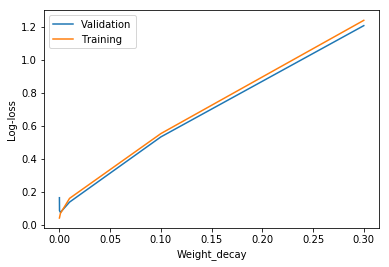

In [52]:
xvals = weight_decay
yvals = outputs2
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
plt.legend()
#plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('Weight_decay')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()

In [53]:
drop_out_rates = list(np.arange(0,11)/10)
M = 2000
learning_rate = .0005
np_epoch = 10

In [ ]:
outputs3 = []
for p in drop_out_rates:
    net2 = get_model_three_layer(M, p)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    outputs3.append(train_model(train_loader,\
    test_loader, num_epochs=4, model=net, optimizer=optimizer))

Epoch [1/4], Loss: 0.5919
Epoch [1/4], Loss: 0.4474
Epoch [1/4], Loss: 0.3707
Epoch [1/4], Loss: 0.3260
Epoch [1/4], Loss: 0.2922
Epoch [1/4], Loss: 0.2672
Epoch [1/4], Loss: 0.2498
Epoch [1/4], Loss: 0.2357
Epoch [1/4], Loss: 0.2236
Epoch [1/4], Loss: 0.2195
Epoch [1/4], Valid Accuracy: 96.6900, Valid Loss: 0.1041
Epoch [2/4], Loss: 0.2075
Epoch [2/4], Loss: 0.1977
Epoch [2/4], Loss: 0.1884
Epoch [2/4], Loss: 0.1813
Epoch [2/4], Loss: 0.1745
Epoch [2/4], Loss: 0.1690
Epoch [2/4], Loss: 0.1637
Epoch [2/4], Loss: 0.1588
Epoch [2/4], Loss: 0.1548
Epoch [2/4], Loss: 0.1534
Epoch [2/4], Valid Accuracy: 96.5900, Valid Loss: 0.1123
Epoch [3/4], Loss: 0.1489
Epoch [3/4], Loss: 0.1448
Epoch [3/4], Loss: 0.1405
Epoch [3/4], Loss: 0.1369
Epoch [3/4], Loss: 0.1337
Epoch [3/4], Loss: 0.1309
Epoch [3/4], Loss: 0.1281
Epoch [3/4], Loss: 0.1256
Epoch [3/4], Loss: 0.1237
Epoch [3/4], Loss: 0.1227
Epoch [3/4], Valid Accuracy: 97.5100, Valid Loss: 0.0815
Epoch [4/4], Loss: 0.1198
Epoch [4/4], Loss: 0.11

Epoch [3/4], Loss: 0.0133
Epoch [3/4], Loss: 0.0134
Epoch [3/4], Loss: 0.0130
Epoch [3/4], Loss: 0.0129
Epoch [3/4], Loss: 0.0129
Epoch [3/4], Loss: 0.0126
Epoch [3/4], Loss: 0.0128
Epoch [3/4], Loss: 0.0125
Epoch [3/4], Loss: 0.0125
Epoch [3/4], Loss: 0.0124
Epoch [3/4], Valid Accuracy: 98.2900, Valid Loss: 0.1523
Epoch [4/4], Loss: 0.0125
Epoch [4/4], Loss: 0.0126
Epoch [4/4], Loss: 0.0123
Epoch [4/4], Loss: 0.0121
Epoch [4/4], Loss: 0.0121
Epoch [4/4], Loss: 0.0119
Epoch [4/4], Loss: 0.0117
Epoch [4/4], Loss: 0.0115
Epoch [4/4], Loss: 0.0114
Epoch [4/4], Loss: 0.0114
Epoch [4/4], Valid Accuracy: 98.0600, Valid Loss: 0.1463
Epoch [1/4], Loss: 0.0048
Epoch [1/4], Loss: 0.0034
Epoch [1/4], Loss: 0.0058
Epoch [1/4], Loss: 0.0081
Epoch [1/4], Loss: 0.0104
Epoch [1/4], Loss: 0.0126
Epoch [1/4], Loss: 0.0129
Epoch [1/4], Loss: 0.0130
Epoch [1/4], Loss: 0.0147
Epoch [1/4], Loss: 0.0145
Epoch [1/4], Valid Accuracy: 98.0700, Valid Loss: 0.1843
Epoch [2/4], Loss: 0.0138
Epoch [2/4], Loss: 0.01

In [ ]:
xvals = drop_out_rates
yvals = outputs3
plt.plot(xvals, [v for _,v,_ in yvals], label = 'Validation')
plt.plot(xvals, [t for _,_,t in yvals], label = 'Training')
#plt.plot(xvals, [k for k,_,_ in yvals], label = 'Prediction')
plt.legend()
#plt.xscale('log')
# plt.show()
#plt.plot(xvals, newyvals, ’r--’)
#plt.plot(xvals, newyvals, ’r--’)
#plt.title(’Example plots’)
plt.xlabel('drop out rates')
plt.ylabel('Log-loss')
# plt.show()
plt.figure()